In [1]:
import ray
import os
import time
from ray import tune
from pyhdfs import HdfsClient
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost_ray import RayXGBRFRegressor, RayParams
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import pickle
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [2]:
ray.shutdown()
ray.init()

2022-11-23 22:36:59,117	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.6
Ray version:,2.1.0
Dashboard:,http://127.0.0.1:8265


In [3]:
nodes = ["127.0.0.1"]
client = HdfsClient(hosts=nodes, user_name="bigdata2022-VirtualBox")
df=pd.read_csv(client.open("hdfs://localhost:9870/user/bigdata2022/datasets/big_data_project/taxi_dataset_EDA_reduct.csv"))

In [4]:
df.head()
#seed=42

,Unnamed: 0,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,dropoff_month,...,dropoff_day_Monday,dropoff_day_Saturday,dropoff_day_Sunday,dropoff_day_Thursday,dropoff_day_Tuesday,dropoff_day_Wednesday,store_and_fwd_flag_Y,pickup_timezone,dropoff_timezone,distance
0,1457973,2,1,-73.984863,40.748692,-74.008369,40.736935,721,4,4,...,0,0,0,0,1,0,0,3,3,1.474873
1,1431240,2,1,-73.980560,40.747429,-74.031090,40.742519,946,4,4,...,0,0,0,0,0,1,0,3,3,2.667464
2,1440158,2,6,-73.984299,40.769943,-73.791130,40.644459,1816,5,5,...,0,0,0,0,0,0,0,1,1,13.327966
3,1456819,1,1,-73.990440,40.775364,-73.979240,40.774212,451,2,2,...,0,0,0,0,0,0,0,1,1,0.591565
4,1451682,2,1,-74.005150,40.719147,-73.987083,40.758945,2558,6,6,...,0,0,0,0,0,1,0,2,2,2.908757


In [5]:
#print("\nDataset statistics:\n", df.describe())

In [6]:
threshold_max=0.01
threshold_min=0.05
lower_threshold = df['trip_duration'].quantile(threshold_min)
upper_threshold = df['trip_duration'].quantile(1 - threshold_max)

df = df[(df['trip_duration'] >= lower_threshold) & (df['trip_duration'] <= upper_threshold)]

print(df.trip_duration.max())
print(df.trip_duration.min())

3419
181


In [7]:
df = df[df.passenger_count <= 6]
df = df[df.passenger_count != 0]

In [8]:
df['trip_duration_hour'] = df['trip_duration'] / 60

In [9]:
X = df.drop(['trip_duration_hour','Unnamed: 0'], axis=1)
t = df['trip_duration_hour']

In [10]:
X_train, X_test, t_train, t_test = train_test_split(X, t, train_size=0.75, random_state=5)
X_train.shape
X_test.shape
t_train.shape
t_test.shape

(11751,)

In [11]:
start_time=time.time()

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
ray_param = RayParams(
                      num_actors=4,
                      cpus_per_actor=1
                   ) 

In [14]:
model = RayXGBRFRegressor(n_jobs=4, 
                          #random_state=5,
                          max_depth= 3,
                          min_child_weight= 0.3361,
                          gamma= 14.96,
                          learning_rate= 0.243,
                          subsample= 0.53,
                          colsample_bylevel= 1.0,
                          colsample_bytree= 0.6099
        )

In [15]:
#param_grid = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 #             'min_child_weight': np.arange(0.0001, 0.5, 0.001),
  #            'gamma': np.arange(0.0,40.0,0.005),
   #           'learning_rate': np.arange(0.0005,0.3,0.0005),
    #          'subsample': np.arange(0.01,1.0,0.01),
     #         'colsample_bylevel': np.round(np.arange(0.1,1.0,0.01)),
      #        'colsample_bytree': np.arange(0.1,1.0,0.01)
       #      }   

In [16]:
#grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring="r2")
#grid_result = grid_search.fit(X_train,t_train)

In [17]:
model.fit(X_train, t_train, ray_params=ray_param)

/home/bigdata2022/.local/lib/python3.10/site-packages/xgboost_ray/sklearn.py:307: UserWarning: `ray_params` is not `None` and will override the `n_jobs` attribute.
  warnings.warn("`ray_params` is not `None` and will override "
2022-11-23 22:37:03,701	INFO main.py:1035 -- [RayXGBoost] Created 4 new actors (4 total actors). Waiting until actors are ready for training.
2022-11-23 22:37:08,837	INFO main.py:1080 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=10135) [22:37:09] task [xgboost.ray]:139963500692096 got new rank 0
(_RemoteRayXGBoostActor pid=10136) [22:37:09] task [xgboost.ray]:140681231549056 got new rank 1
(_RemoteRayXGBoostActor pid=10184) [22:37:09] task [xgboost.ray]:140364423529088 got new rank 2
(_RemoteRayXGBoostActor pid=10210) [22:37:09] task [xgboost.ray]:140169834234448 got new rank 3
2022-11-23 22:37:17,174	INFO main.py:1575 -- [RayXGBoost] Finished XGBoost training on training data with total N=35,252 in 14.35 seconds (8.24 pure XGBoost trai

RayXGBRFRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                  colsample_bylevel=1.0, colsample_bytree=0.6099,
                  early_stopping_rounds=None, enable_categorical=False,
                  eval_metric=None, feature_types=None, gamma=14.96, gpu_id=-1,
                  grow_policy='depthwise', importance_type=None,
                  interaction_constraints='', learning_rate=0.243, max_bin=256,
                  max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
                  max_depth=3, max_leaves=0, min_child_weight=0.3361,
                  missing=nan, monotone_constraints='()', n_estimators=100,
                  n_jobs=4, num_parallel_tree=100, objective='reg:squarederror',
                  predictor='auto', random_state=0, ...)

In [18]:
params = model.get_xgb_params()
print(params)

{'colsample_bynode': 0.8, 'learning_rate': 0.243, 'reg_lambda': 1e-05, 'subsample': 0.53, 'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1.0, 'colsample_bytree': 0.6099, 'eval_metric': None, 'gamma': 14.96, 'gpu_id': -1, 'grow_policy': 'depthwise', 'interaction_constraints': '', 'max_bin': 256, 'max_cat_threshold': 64, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 3, 'max_leaves': 0, 'min_child_weight': 0.3361, 'monotone_constraints': '()', 'n_jobs': 4, 'num_parallel_tree': 100, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'tree_method': 'approx', 'validate_parameters': 1, 'verbosity': None}


In [19]:
#model_saved='finalized_model.sav'
#pickle.dump(model, open(model_saved, 'wb'))

In [20]:
pred_ray = model.predict(X_test)
print(pred_ray)
print(t_test)

2022-11-23 22:37:17,650	INFO main.py:1620 -- [RayXGBoost] Created 4 remote actors.
2022-11-23 22:37:22,654	INFO main.py:1637 -- [RayXGBoost] Starting XGBoost prediction.


[5.77486   5.77486   3.6528783 ... 7.6754756 7.697772  2.86771  ]
11739    32.916667
17517    19.166667
28122     7.983333
14469    15.850000
12608    20.350000
           ...    
31387     6.333333
10330     5.966667
31828    18.733333
26956    16.300000
14812     9.966667
Name: trip_duration_hour, Length: 11751, dtype: float64


In [21]:
MSE=mean_squared_error(t_test, pred_ray)
print(MSE)
R2=r2_score(t_test, pred_ray)
print(R2)

173.1319347234599
-0.9361679054148773


In [22]:
print(time.time()-start_time)

20.69395351409912


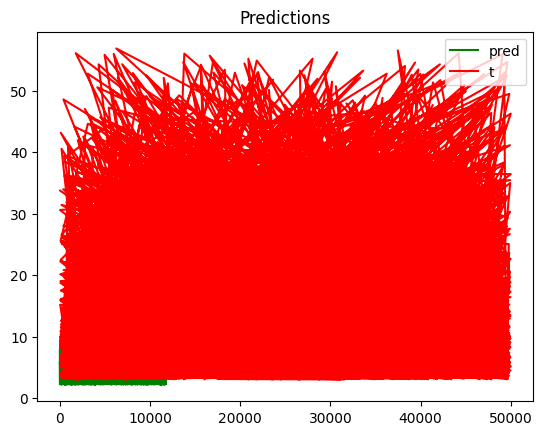

In [23]:
plt.figure('Predictions')
plt.title('Predictions')
plt.plot(pred_ray, color='g', label='pred')
plt.plot(t_test, color='r', label='t')
plt.legend()
plt.show()